# Feature Analysis Notebook

## Introduction

This notebook analyzes deepfake-specific features including frequency domain analysis, noise patterns, color consistency, texture analysis, and dimensionality reduction visualizations.


In [10]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))


In [11]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.fft import dct
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))

from eda.visualization import EDAVisualizer
from eda.artifact_detector import ArtifactDetector

%matplotlib inline


## 1. Load Sample Images


In [13]:
# Load sample real and fake images
DATASET_PATH = r"C:\Users\HP\Documents\QUEST\deepfake project\dataset"

# Example: Load images (implement your loading logic)
import os
from pathlib import Path
import cv2

real_images = []
fake_images = []

real_dir = Path(DATASET_PATH) / "real"
fake_dir = Path(DATASET_PATH) / "fake"

if real_dir.exists():
    for img_file in list(real_dir.glob("*.jpg"))[:10] + list(real_dir.glob("*.png"))[:10]:
        img = cv2.imread(str(img_file))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            real_images.append(img)

if fake_dir.exists():
    for img_file in list(fake_dir.glob("*.jpg"))[:10] + list(fake_dir.glob("*.png"))[:10]:
        img = cv2.imread(str(img_file))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            fake_images.append(img)

print(f"Loaded {len(real_images)} real and {len(fake_images)} fake images")


Loaded 10 real and 10 fake images


## 2. Frequency Domain Analysis

Compare frequency spectra between real and fake images.


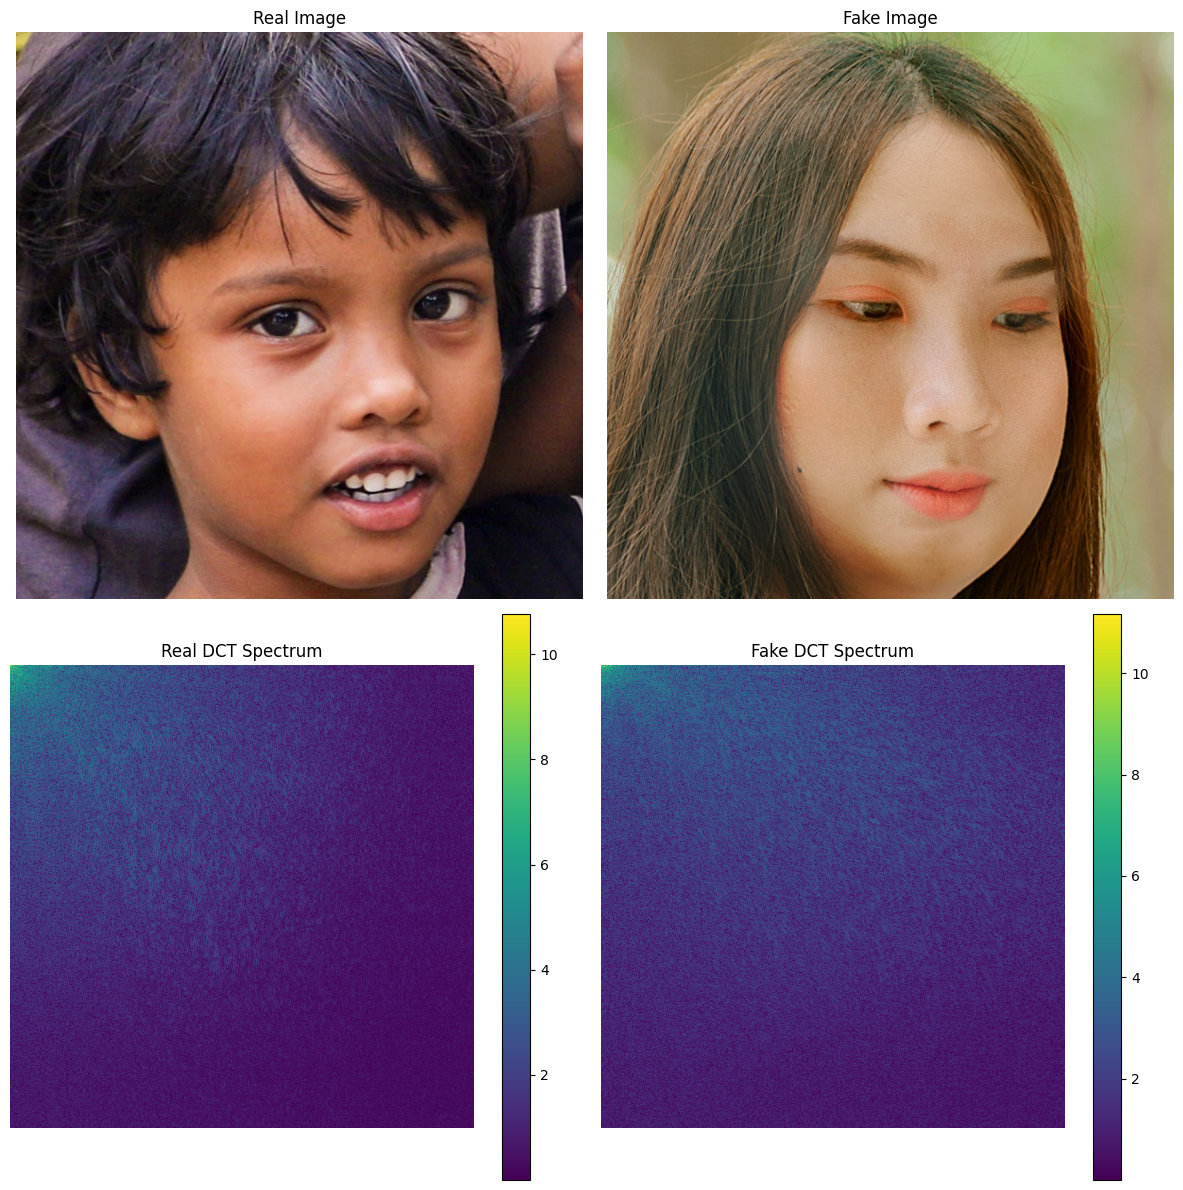

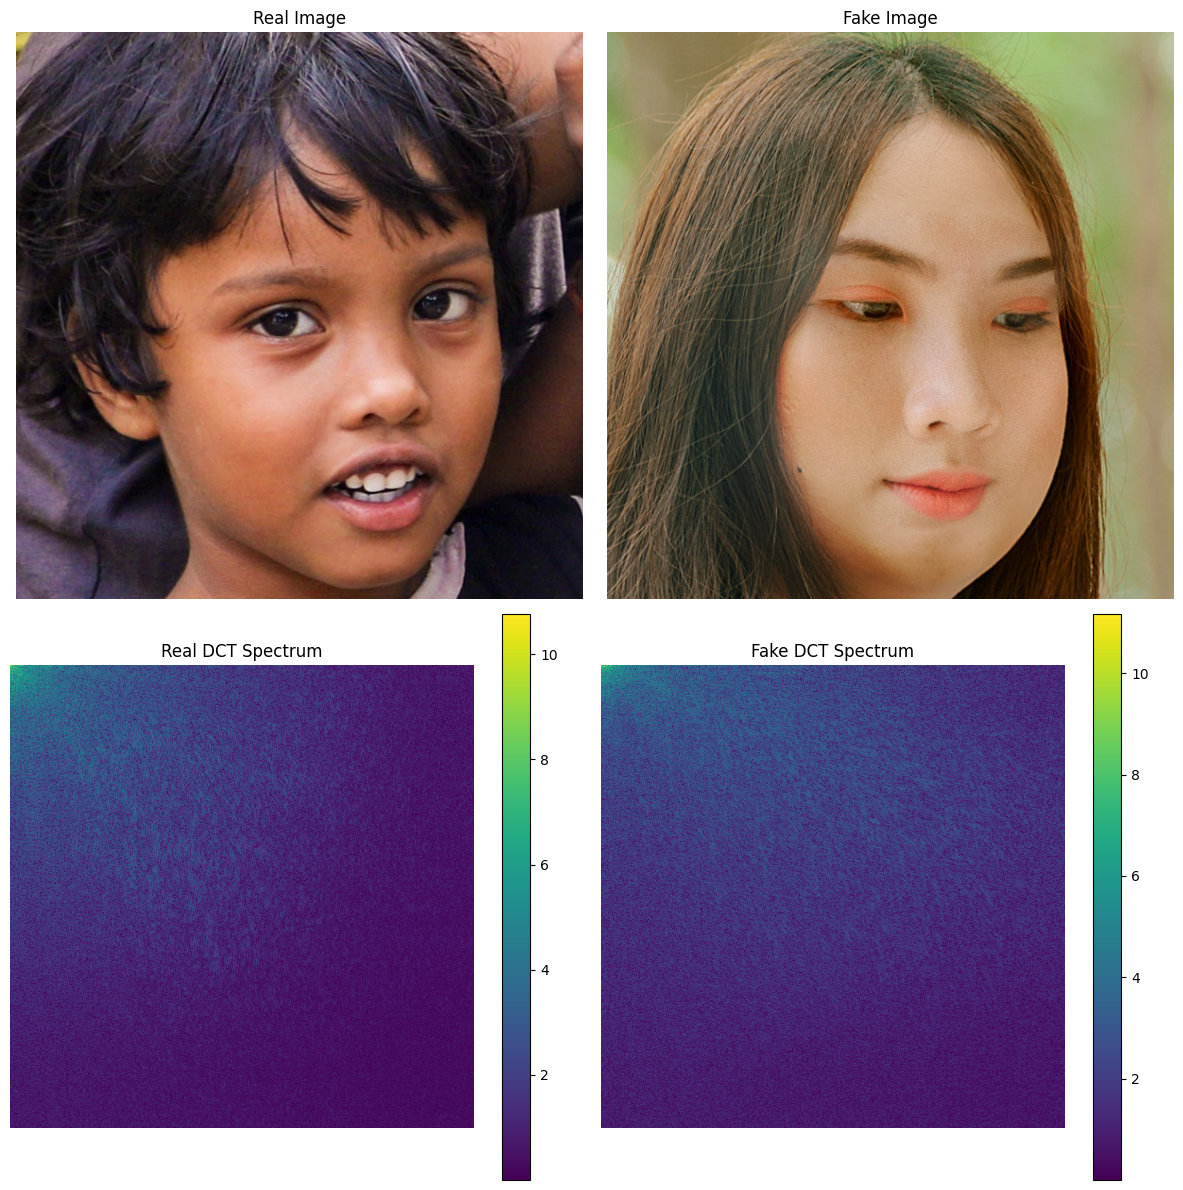

In [15]:
# Compare frequency spectra using DCT
visualizer = EDAVisualizer()

# Select sample images
if len(real_images) > 0 and len(fake_images) > 0:
    real_sample = real_images[0]
    fake_sample = fake_images[0]
    
    # Plot frequency comparison using DCT
    fig = visualizer.plot_frequency_comparison(
        real_sample, fake_sample,
        #save_path="../reports/visualizations/frequency_comparison_dct.png"
    )
    plt.show()
    
    # Alternative: Direct DCT spectrum plot
    fig = visualizer.plot_frequency_spectrum(
        real_sample, fake_sample,
        #save_path="../reports/visualizations/frequency_spectrum_dct.png"
    )
    plt.show()
else:
    print("No images loaded. Please check dataset path.")


## 3. Statistical Distribution Comparison

Compare distributions between real and fake images using statistical tests.


In [16]:
# Compare distributions using the new compare_distributions function
from eda.statistical_tests import compare_distributions

if len(real_images) > 0 and len(fake_images) > 0:
    # Compare pixel distributions
    p_value = compare_distributions(
        real_images[:50],  # Sample for speed
        fake_images[:50],
        test_type='ks',  # Kolmogorov-Smirnov test
        alpha=0.05
    )
    
    print(f"Kolmogorov-Smirnov test p-value: {p_value}")
    
    # Run all tests
    all_results = compare_distributions(
        real_images[:50],
        fake_images[:50],
        test_type='all',
        alpha=0.05
    )
    
    print("\nAll statistical test results:")
    for test_name, result in all_results.items():
        print(f"{test_name}:")
        print(f"  p-value: {result['p_value']:.4f}")
        print(f"  Significant: {result['significant']}")
        print(f"  Interpretation: {result['interpretation']}")
else:
    print("No images loaded.")


Kolmogorov-Smirnov test p-value: 0.0

All statistical test results:
kolmogorov_smirnov:
  p-value: 0.0000
  Significant: True
  Interpretation: Distributions are significantly different
t_test:
  p-value: 0.0000
  Significant: True
  Interpretation: Means are significantly different
mann_whitney:
  p-value: 0.0000
  Significant: True
  Interpretation: Distributions are significantly different


## 4. Feature Importance Analysis

Analyze which artifact features are most important for deepfake detection.


In [17]:
# Analyze feature importance
from eda.difficulty_estimator import FeatureImportanceAnalyzer

if len(real_images) > 0 and len(fake_images) > 0:
    importance_analyzer = FeatureImportanceAnalyzer()
    importance_results = importance_analyzer.analyze_feature_importance(
        real_images[:50],
        fake_images[:50]
    )
    
    print("=== Feature Importance Analysis ===")
    print("\nImportance Scores:")
    for feature, score in importance_results['importance_scores'].items():
        print(f"  {feature}: {score:.3f}")
    
    print(f"\nMost Important Feature: {importance_results['most_important']}")
    
    print("\nRecommendations:")
    for rec in importance_results['recommendations']:
        print(f"  - {rec}")
else:
    print("No images loaded.")


=== Feature Importance Analysis ===

Importance Scores:
  warping: 0.234
  lighting: 0.021
  blending: 0.431
  jpeg: 0.001
  frequency: 1.000

Most Important Feature: frequency

Recommendations:
  - Focus on frequency artifacts - they are most prevalent in this dataset.
  - Frequency domain features are important. Consider using frequency analysis branch in model.
  - Blending artifacts are significant. Focus on boundary detection.


## 5. Data Difficulty Estimation

Estimate how difficult the dataset is for deepfake detection.


In [18]:
# Estimate dataset difficulty
from eda.difficulty_estimator import DataDifficultyEstimator

if len(real_images) > 0 and len(fake_images) > 0:
    difficulty_estimator = DataDifficultyEstimator()
    difficulty_results = difficulty_estimator.estimate_difficulty(
        real_images[:100],
        fake_images[:100]
    )
    
    print("=== Data Difficulty Estimation ===")
    print(f"Difficulty Score: {difficulty_results['difficulty_score']:.3f} (0=Easy, 1=Hard)")
    print(f"Difficulty Level: {difficulty_results['difficulty_level']}")
    print(f"Artifact Visibility: {difficulty_results['artifact_visibility']:.3f}")
    print(f"Statistical Separability: {difficulty_results['statistical_separability']:.3f}")
    
    print("\nRecommendations:")
    for rec in difficulty_results['recommendations']:
        print(f"  - {rec}")
else:
    print("No images loaded.")


=== Data Difficulty Estimation ===
Difficulty Score: 0.719 (0=Easy, 1=Hard)
Difficulty Level: Hard
Artifact Visibility: 0.339
Statistical Separability: 0.180

Recommendations:
  - Dataset is challenging. Use advanced architectures and extensive data augmentation.
  - Consider using self-supervised learning or transfer learning from larger datasets.
  - Focus on frequency domain features and artifact-specific detection.
